# KOH Posterior Analysis using Mici

In [1]:
from models import toymodel as KOHmodel
from data.dataloader import DataLoader
from kohgpjax.mappings import mapRto01, map01toR, mapRto0inf, map0inftoR
from jax import jit, grad

import numpy as np
import matplotlib.pyplot as plt

import mici
import arviz

from truefuncs import zeta
eta = zeta

plot_style = {
    'mathtext.fontset': 'cm',
    'font.family': 'serif',
    'axes.titlesize': 10,
    'axes.labelsize': 10,
    'xtick.labelsize': 6,
    'ytick.labelsize': 6,
    'legend.fontsize': 8,
    'legend.frameon': False,
    'axes.linewidth': 0.5,
    'lines.linewidth': 0.5,
    'axes.labelpad': 2.,
    'figure.dpi': 150,
}

/Users/jamesbriant/miniforge3/envs/py311/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/jamesbriant/miniforge3/envs/py311/lib/python3.11/site-packages/cola/backends/backends.py:75: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  torch.utils._pytree._register_pytree_node(cls, tree_flatten, tree_unflatten)


# The data

In [2]:
dataloader = DataLoader('data/toy/field_sin.csv', 'data/toy/sim_sin.csv')
data = dataloader.get_data()
model = KOHmodel.Model(*data)

tmax = dataloader.t_max
tmin = dataloader.t_min

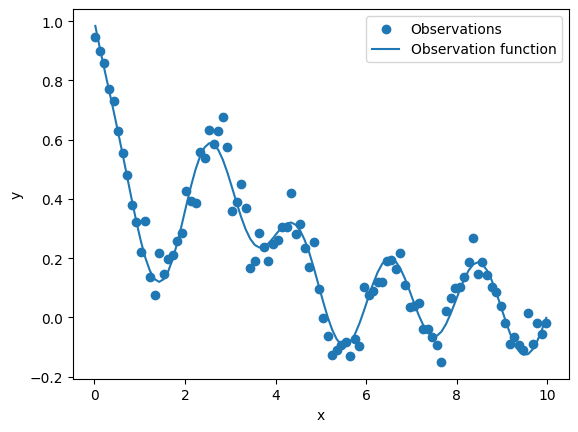

In [3]:
fig, ax = plt.subplots(1, 1)
ax.scatter(dataloader.xf, dataloader.yf, label='Observations')
def disc(x):
    return 0.14*np.sin(x*np.pi)
ax.plot(dataloader.xf, zeta(dataloader.xf, 0.4)+disc(dataloader.xf), label='Observation function')
# for t in [0.2, 0.3, 0.4, 0.5, 0.6]:
#     rows = dataloader.tc==t
#     ax.plot(dataloader.xc[rows], dataloader.yc[rows], '--', label=f'Simulator t={t}')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.legend()
plt.show()

# MCMC Setup

In [4]:
theta_0 = 0.5

ell_eta_0_0 = 1 # np.sqrt(np.var(dataloader.xf))/3
ell_eta_1_0 = 0.3 # np.sqrt(np.var(dataloader.tc))/3
ell_delta_0_0 = 1 # np.sqrt(np.var(dataloader.xf))/5

lambda_eta_0 = 1
lambda_delta_0 = 30
lambda_epsilon_0 = 400
lambda_epsilon_eta_0 = 10000

init_states = np.array([[
    map01toR(theta_0), 
    map0inftoR(ell_eta_0_0),
    map0inftoR(ell_eta_1_0),
    map0inftoR(ell_delta_0_0),
    map0inftoR(lambda_eta_0),
    map0inftoR(lambda_delta_0),
    map0inftoR(lambda_epsilon_0),
    map0inftoR(lambda_epsilon_eta_0),
]])

Build the transform function to translate Mici's unbounded parameters into bounded GPJAX parameters.
This is passed to KOHGPJax.

In [5]:
param_transform_mici_to_gpjax = lambda x: [
    [ # theta (calibration) parameters
        mapRto01(x[0]),
    ],
    [ # lengthscale parameters
        mapRto0inf(x[1]), 
        mapRto0inf(x[2]), 
        mapRto0inf(x[3]),
    ],
    [ # lambda (variance) parameters
        mapRto0inf(x[4]), 
        mapRto0inf(x[5]), 
        mapRto0inf(x[6]), 
        mapRto0inf(x[7]),
    ]
]

Build the function for evaluating the negative log posterior density.

This function is jitted and grad jitted using JAX. Finally the JAX functions are wrapped into a numpy function for clean interactions with Mici.

In [6]:
jitted_neg_log_posterior_density = jit(
    model.get_KOH_neg_log_pos_dens_func(
        param_transform_mici_to_gpjax
    )
)
grad_neg_log_posterior_density = jit(grad(
    model.get_KOH_neg_log_pos_dens_func(
        param_transform_mici_to_gpjax
    )
))

def neg_log_pos_dens(x):
    return np.asarray(jitted_neg_log_posterior_density(x))

def grad_neg_log_pos_dens(x):
    return np.asarray(grad_neg_log_posterior_density(x))

##### Mici #####
system = mici.systems.EuclideanMetricSystem(
    neg_log_dens=neg_log_pos_dens,
    grad_neg_log_dens=grad_neg_log_pos_dens,
)
integrator = mici.integrators.LeapfrogIntegrator(system)

# Running MCMC algorithm

In [7]:
seed = 1234
n_chain = 1
rng = np.random.default_rng(seed)

##### Mici sampler and adapters #####
# sampler = mici.samplers.StaticMetropolisHMC(system, integrator, rng, n_step=3)
sampler = mici.samplers.DynamicMultinomialHMC(system, integrator, rng)
adapters = [
    mici.adapters.DualAveragingStepSizeAdapter(0.8),
    mici.adapters.OnlineCovarianceMetricAdapter()
]

def trace_func(state):
    return {
        'm_theta': state.pos[0], 
        'm_ell_eta_0': state.pos[1], 
        'm_ell_eta_1': state.pos[2],
        'm_ell_delta_0': state.pos[3],
        'm_lambda_eta': state.pos[4],
        'm_lambda_delta': state.pos[5],
        'm_lambda_epsilon': state.pos[6],
        'm_lambda_epsilon_eta': state.pos[7],
        'hamiltonian': system.h(state)
    }


n_warm_up_iter = 100
n_warm_up_iter = 5
# n_main_iter = 500
params_transformed_mean = {}
params_transformed_std = {}
# n_main_iters = [30, 50, 75, 100, 150, 200, 300, 500, 700, 900, 1200, 1500, 2000, 3000, 4000, 5000]: #, 7500, 10000, 14000, 20000]:
n_main_iters = [30, 50, 75]
# n_main_iters = [30, 50, 75, 100, 150, 200, 300, 500, 700, 900, 1200]
for N in n_main_iters:
    final_states, traces, stats = sampler.sample_chains(
        n_warm_up_iter, 
        N, 
        init_states, 
        adapters=adapters, 
        n_process=n_chain, # only 1 works on MacOS
        trace_funcs=[trace_func]
    )

    for var, trace in traces.items():
        if var == 'hamiltonian':
            continue
        var_name = var.split('m_')[1]
        if var_name == 'theta':
            params_transformed_mean.setdefault(var_name, []).append(np.mean(mapRto01(trace[0])*(tmax-tmin) + tmin))
            params_transformed_std.setdefault(var_name, []).append(np.std(mapRto01(trace[0])*(tmax-tmin) + tmin))
        elif var_name.startswith('ell'):
            params_transformed_mean.setdefault(var_name, []).append(np.mean(mapRto0inf(trace[0])))
            params_transformed_std.setdefault(var_name, []).append(np.std(mapRto0inf(trace[0])))
        elif var_name.startswith('lambda'):
            params_transformed_mean.setdefault(var_name, []).append(np.mean(mapRto0inf(trace[0])))
            params_transformed_std.setdefault(var_name, []).append(np.std(mapRto0inf(trace[0])))

    print(params_transformed_mean)

/Users/jamesbriant/miniforge3/envs/py311/lib/python3.11/site-packages/cola/backends/backends.py:75: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  torch.utils._pytree._register_pytree_node(cls, tree_flatten, tree_unflatten)
/Users/jamesbriant/miniforge3/envs/py311/lib/python3.11/site-packages/cola/backends/backends.py:75: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  torch.utils._pytree._register_pytree_node(cls, tree_flatten, tree_unflatten)


Sampling stage: Initial fast adaptive [00:01] > Slow adaptive (1/1) [00:01] > Final fast adaptive [00:00] > Main non-adaptive [00:00]

ZeroDivisionError: division by zero

ZeroDivisionError: division by zero

{'theta': [Array(0.4791849, dtype=float64)], 'ell_eta_0': [Array(2.14739911, dtype=float64)], 'ell_eta_1': [Array(0.24081752, dtype=float64)], 'ell_delta_0': [Array(0.63717496, dtype=float64)], 'lambda_eta': [Array(0.81434484, dtype=float64)], 'lambda_delta': [Array(21.14386416, dtype=float64)], 'lambda_epsilon': [Array(439.04655149, dtype=float64)], 'lambda_epsilon_eta': [Array(120486.55682119, dtype=float64)]}


Sampling stage: Initial fast adaptive [00:00] > Slow adaptive (1/1) [00:06] > Final fast adaptive [00:00] > Main non-adaptive [00:03]

ZeroDivisionError: division by zero

ZeroDivisionError: division by zero

{'theta': [Array(0.4791849, dtype=float64), Array(0.48944116, dtype=float64)], 'ell_eta_0': [Array(2.14739911, dtype=float64), Array(2.12749025, dtype=float64)], 'ell_eta_1': [Array(0.24081752, dtype=float64), Array(0.2441599, dtype=float64)], 'ell_delta_0': [Array(0.63717496, dtype=float64), Array(0.54341471, dtype=float64)], 'lambda_eta': [Array(0.81434484, dtype=float64), Array(0.7222052, dtype=float64)], 'lambda_delta': [Array(21.14386416, dtype=float64), Array(16.57075405, dtype=float64)], 'lambda_epsilon': [Array(439.04655149, dtype=float64), Array(374.50789, dtype=float64)], 'lambda_epsilon_eta': [Array(120486.55682119, dtype=float64), Array(176141.63516893, dtype=float64)]}


Sampling stage: Initial fast adaptive [00:00] > Slow adaptive (1/1) [00:02] > Final fast adaptive [00:00] > Main non-adaptive [00:02]

ZeroDivisionError: division by zero

ZeroDivisionError: division by zero

{'theta': [Array(0.4791849, dtype=float64), Array(0.48944116, dtype=float64), Array(0.46504525, dtype=float64)], 'ell_eta_0': [Array(2.14739911, dtype=float64), Array(2.12749025, dtype=float64), Array(2.13655229, dtype=float64)], 'ell_eta_1': [Array(0.24081752, dtype=float64), Array(0.2441599, dtype=float64), Array(0.21628501, dtype=float64)], 'ell_delta_0': [Array(0.63717496, dtype=float64), Array(0.54341471, dtype=float64), Array(0.56752534, dtype=float64)], 'lambda_eta': [Array(0.81434484, dtype=float64), Array(0.7222052, dtype=float64), Array(0.71405559, dtype=float64)], 'lambda_delta': [Array(21.14386416, dtype=float64), Array(16.57075405, dtype=float64), Array(16.13855495, dtype=float64)], 'lambda_epsilon': [Array(439.04655149, dtype=float64), Array(374.50789, dtype=float64), Array(508.09976585, dtype=float64)], 'lambda_epsilon_eta': [Array(120486.55682119, dtype=float64), Array(176141.63516893, dtype=float64), Array(200298.84755854, dtype=float64)]}


# Analyse MCMC output

In [8]:
# for var in params_transformed_mean:
#     print(var)
#     for i, (mean, std) in enumerate(zip(params_transformed_mean[var], params_transformed_std[var])):
#         print(f'N={n_main_iters[i]}: mean={mean}, std={std}')
#     print()

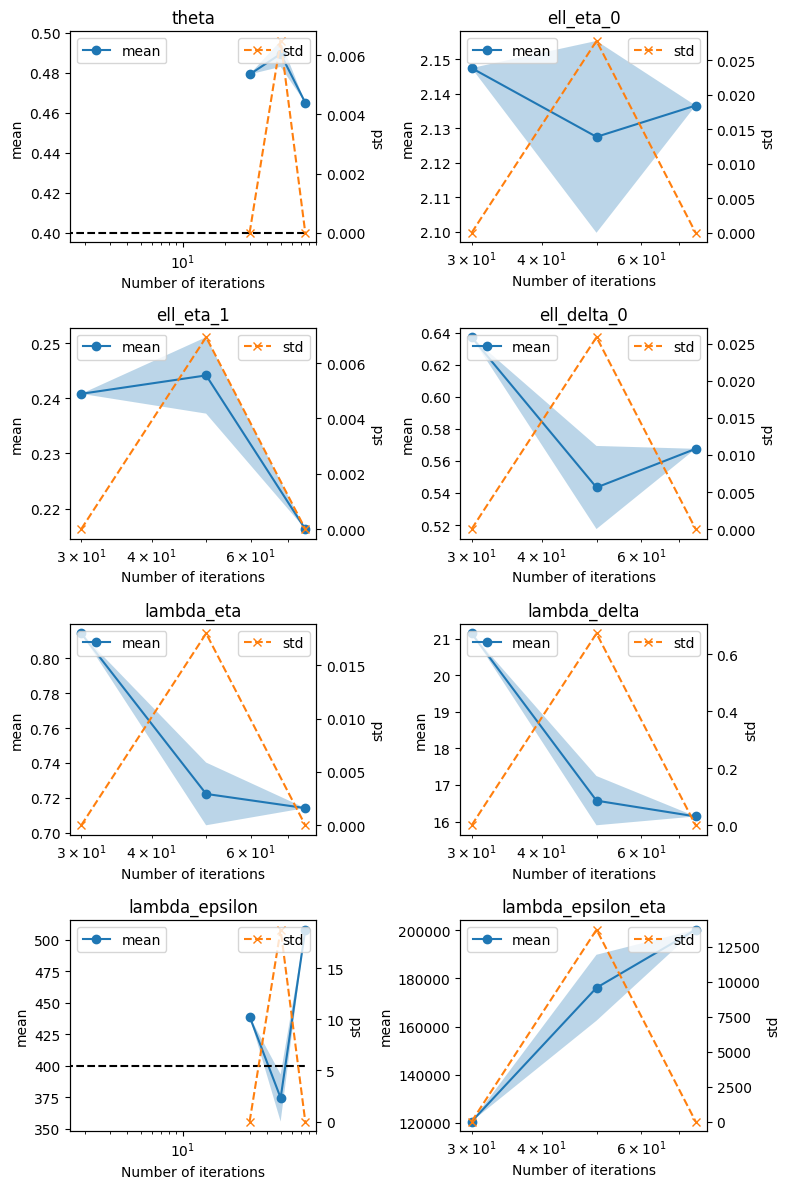

In [9]:
fig, axes = plt.subplots(4, 2, figsize=(8, 12))

for i, var in enumerate(params_transformed_mean):
    ax = axes.flatten()[i]
    ax.set_xscale('log')
    ax.plot(n_main_iters, params_transformed_mean[var], 'o-', label='mean')
    ax.fill_between(
        n_main_iters, 
        np.array(params_transformed_mean[var])-np.array(params_transformed_std[var]), 
        np.array(params_transformed_mean[var])+np.array(params_transformed_std[var]), 
        alpha=0.3
    )
    ax.set_xlabel('Number of iterations')
    ax.set_ylabel('mean')

    ax2 = ax.twinx()
    ax2.plot(n_main_iters, params_transformed_std[var], 'x--', color='tab:orange', label='std')
    ax2.set_ylabel('std')

    ax.legend(loc=2)
    ax2.legend(loc=1)

    ax.set_title(var)

axes[0,0].hlines(0.4, 0, n_main_iters[-1], 'k', '--', label='True value')
axes[3,0].hlines(400, 0, n_main_iters[-1], 'k', '--', label='True value')
plt.tight_layout()
plt.show()